## Denoising Diffusion Probabilistic Models

In [1]:
!git clone https://github.com/Misha24-10/nn_vk_course.git

Cloning into 'nn_vk_course'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 64 (delta 16), reused 52 (delta 7), pack-reused 0
Unpacking objects: 100% (64/64), 20.72 MiB | 10.20 MiB/s, done.


In [2]:
import sys
sys.path.append("/kaggle/working/nn_vk_course/hw_11/diffution/")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Set model parameters

In [5]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1

### Load dataset and train model

In [6]:
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [7]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth, cdf=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 13789108.55it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209890.49it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3916962.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10758483.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

In [9]:
# Train model
trainer.fit(model, train_loader, val_loader)

2024-04-29 18:11:44.830721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 18:11:44.830829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 18:11:44.963821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Sample from model

In [10]:
def gen_sampels(seed=777):
    gif_shape = [3, 3]
    torch.manual_seed(seed)
    sample_batch_size = gif_shape[0] * gif_shape[1]
    n_hold_final = 10
    if model.cdf:
        labels = torch.Tensor(list(range(9))).long()
    else:
        labels = None
    gen_samples = []
    x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t, labels)
        if t % 50 == 0:
            gen_samples.append(x)
    for _ in range(n_hold_final):
        gen_samples.append(x)
    gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
    gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2
    return gen_samples

In [11]:
# Process samples and save as gif
def gen_sampels_prepare(gen_samples):
    gif_shape = [3, 3]
    gen_samples = (gen_samples * 255).type(torch.uint8)
    gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

    def stack_samples(gen_samples, stack_dim):
        gen_samples = list(torch.split(gen_samples, 1, dim=1))
        for i in range(len(gen_samples)):
            gen_samples[i] = gen_samples[i].squeeze(1)
        return torch.cat(gen_samples, dim=stack_dim)
    gen_samples = stack_samples(gen_samples, 2)
    gen_samples = stack_samples(gen_samples, 2)
    return gen_samples

In [13]:
def plot_generate(gen_samples):
    plt.figure()
    f, axarr = plt.subplots(2,2,  figsize=(15, 15)) 
    axarr[0,0].imshow(gen_samples[0,:].moveaxis(2, 0)[0])
    axarr[0,1].imshow(gen_samples[10,:].moveaxis(2, 0)[0])
    axarr[1,0].imshow(gen_samples[20,:].moveaxis(2, 0)[0])
    axarr[1,1].imshow(gen_samples[-1,:].moveaxis(2, 0)[0])

<Figure size 640x480 with 0 Axes>

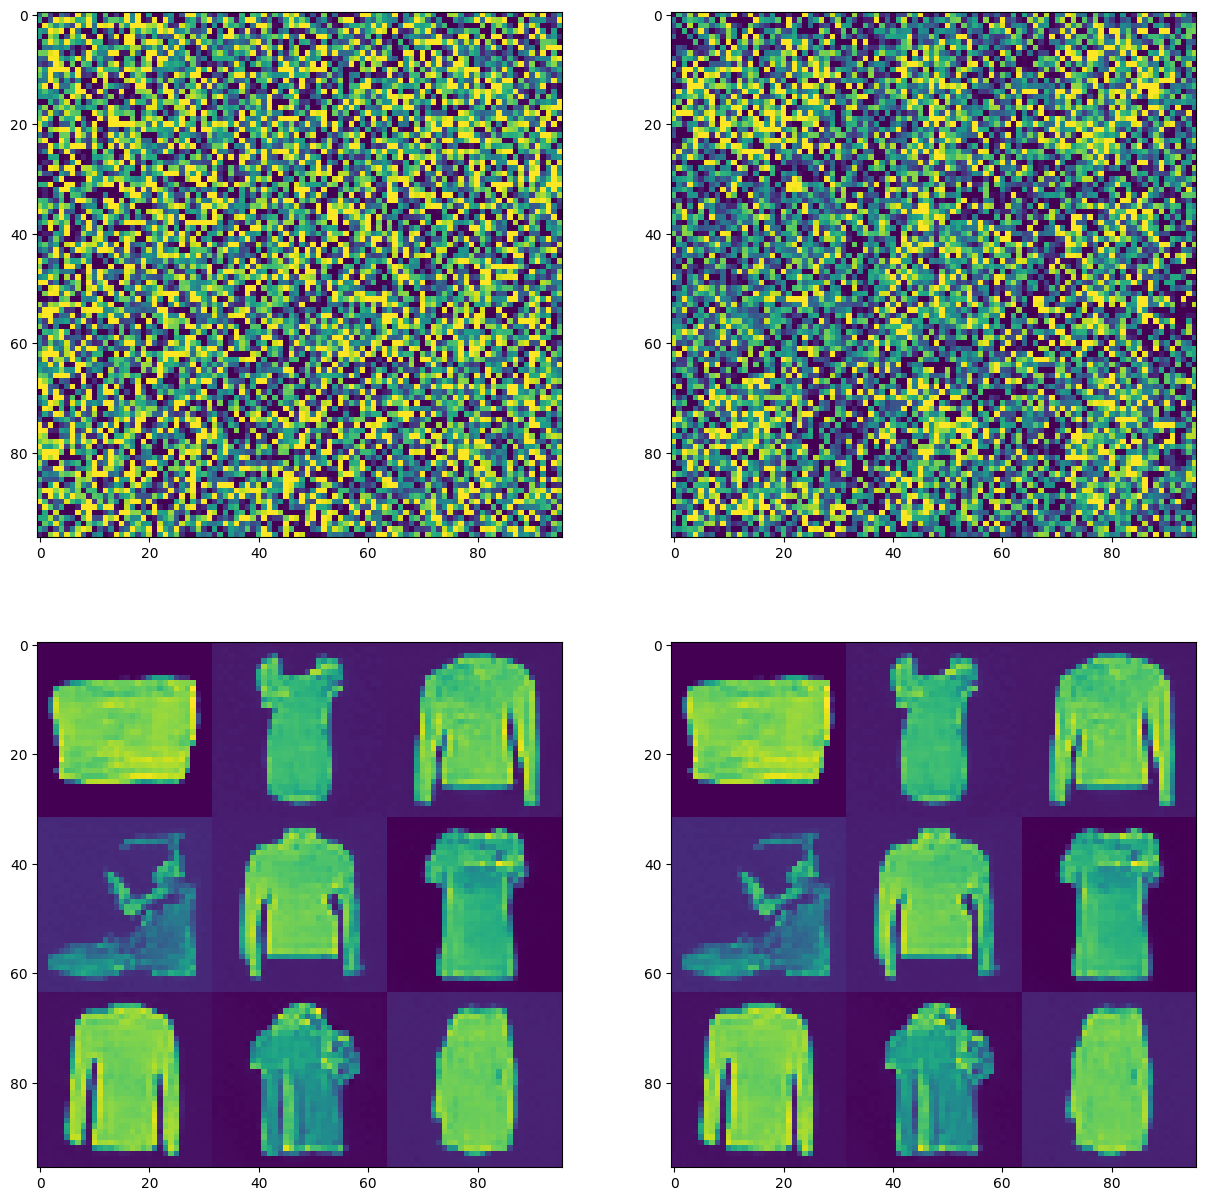

In [14]:
gen_samples = gen_sampels(seed=777)
gen_samples = gen_sampels_prepare(gen_samples)

imageio.mimsave(
    f"pred.gif",
    [Image.fromarray(image.moveaxis(2, 0)[0].numpy().astype(np.uint8)) for image in gen_samples],
    fps=5,
)


plot_generate(gen_samples)

<Figure size 640x480 with 0 Axes>

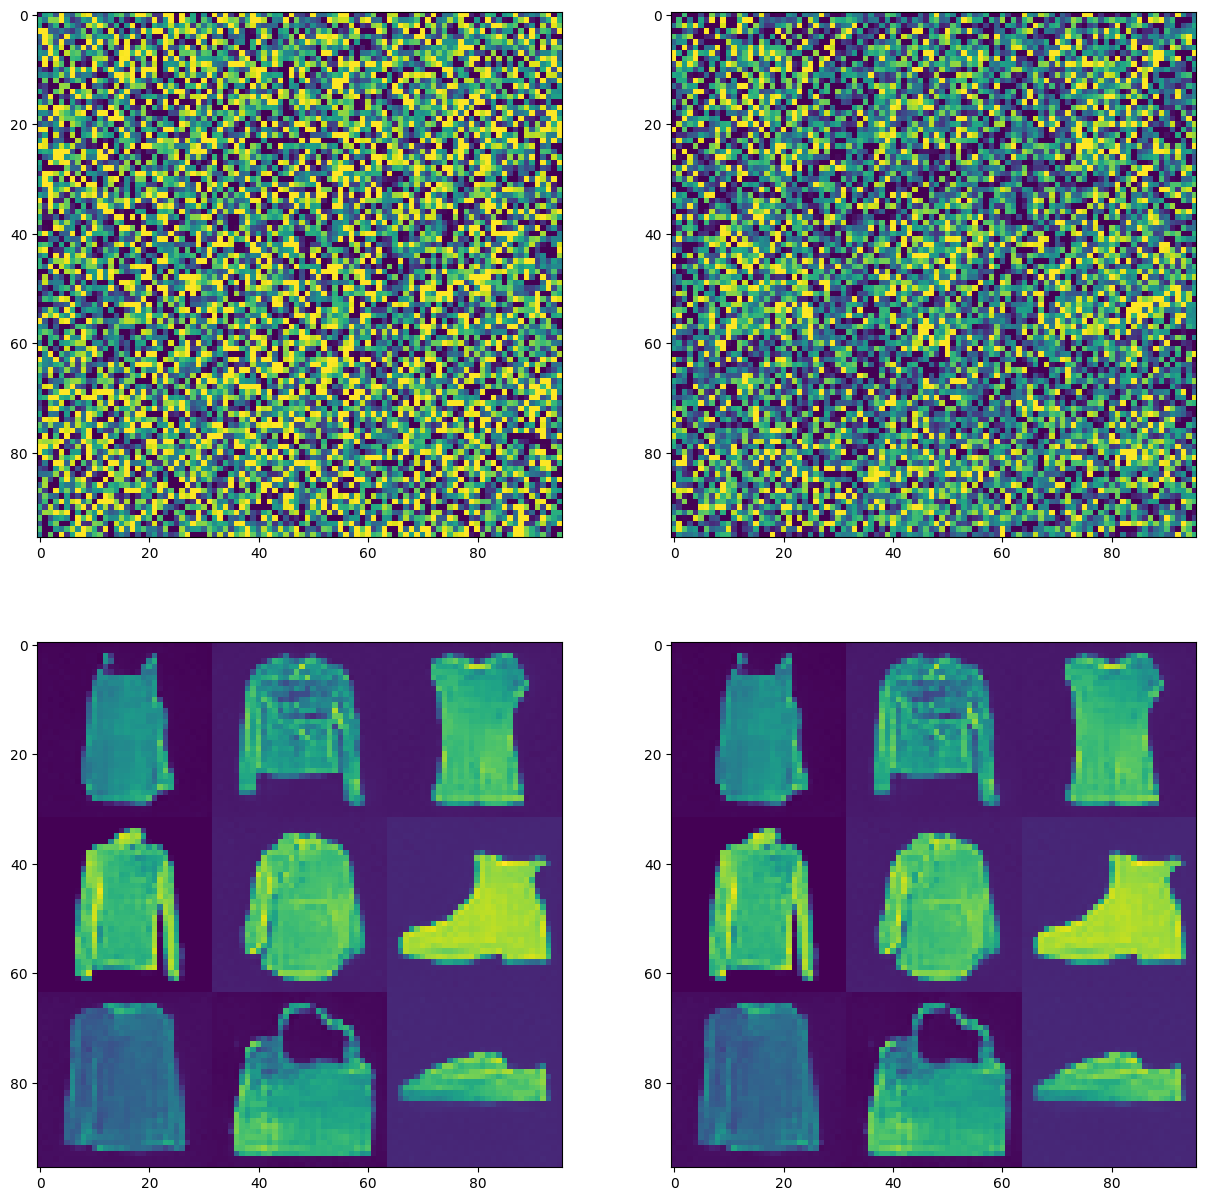

In [15]:
gen_samples = gen_sampels(seed=666)
gen_samples = gen_sampels_prepare(gen_samples)
plot_generate(gen_samples)

<Figure size 640x480 with 0 Axes>

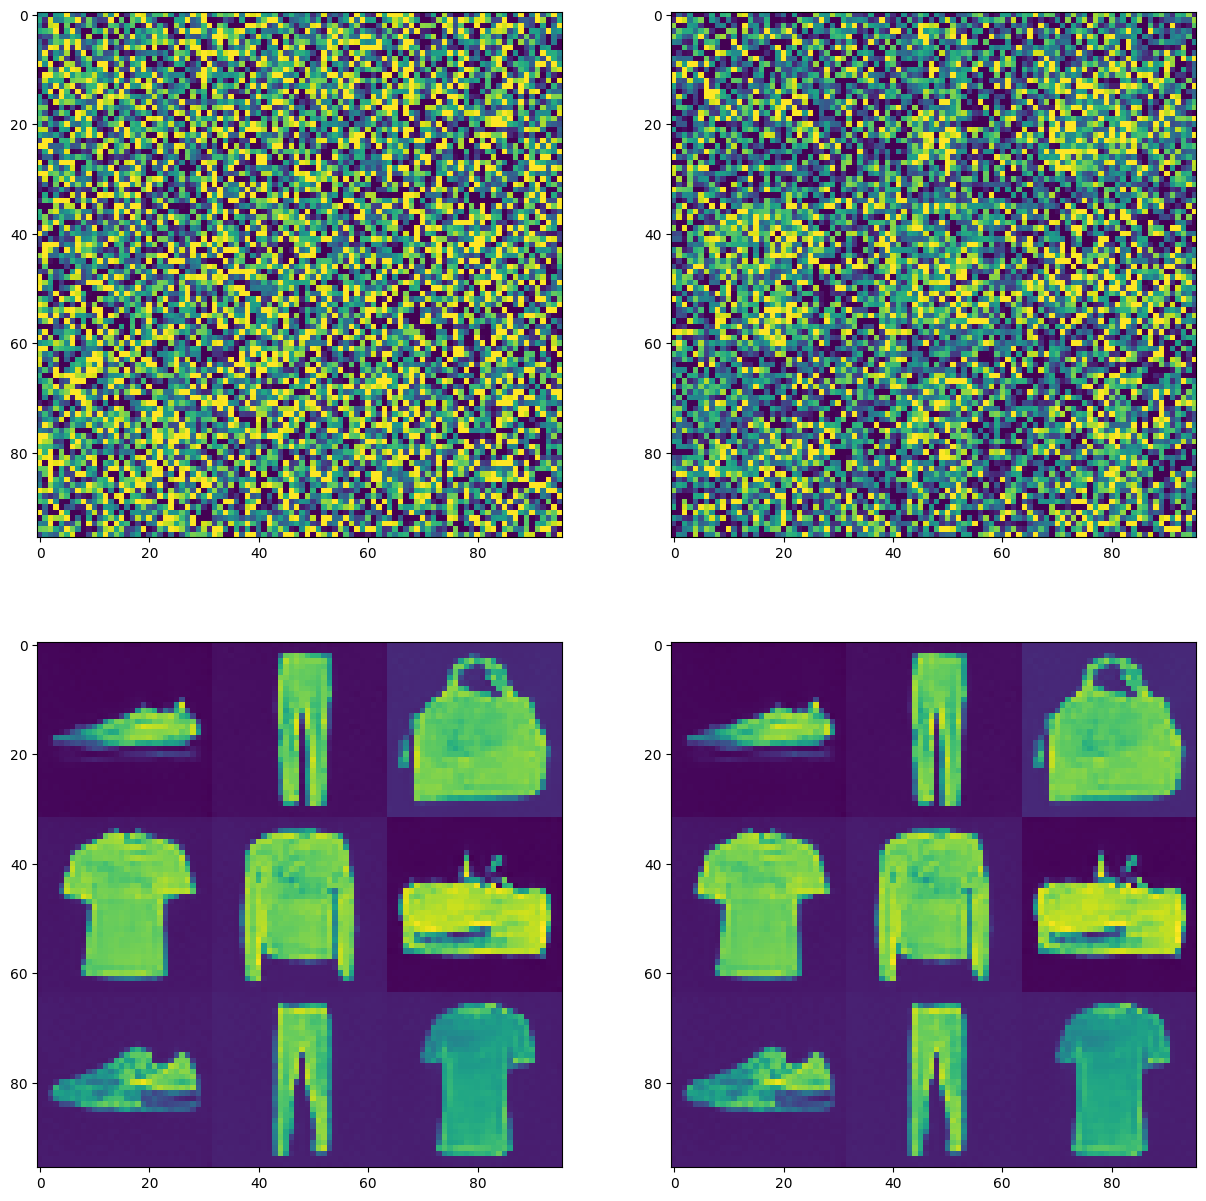

In [16]:
gen_samples = gen_sampels(seed=0)
gen_samples = gen_sampels_prepare(gen_samples)
plot_generate(gen_samples)

# Part 2

In [23]:
max_epoch = 20

In [24]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth, cdf=True)

In [25]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

In [26]:
# Train model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

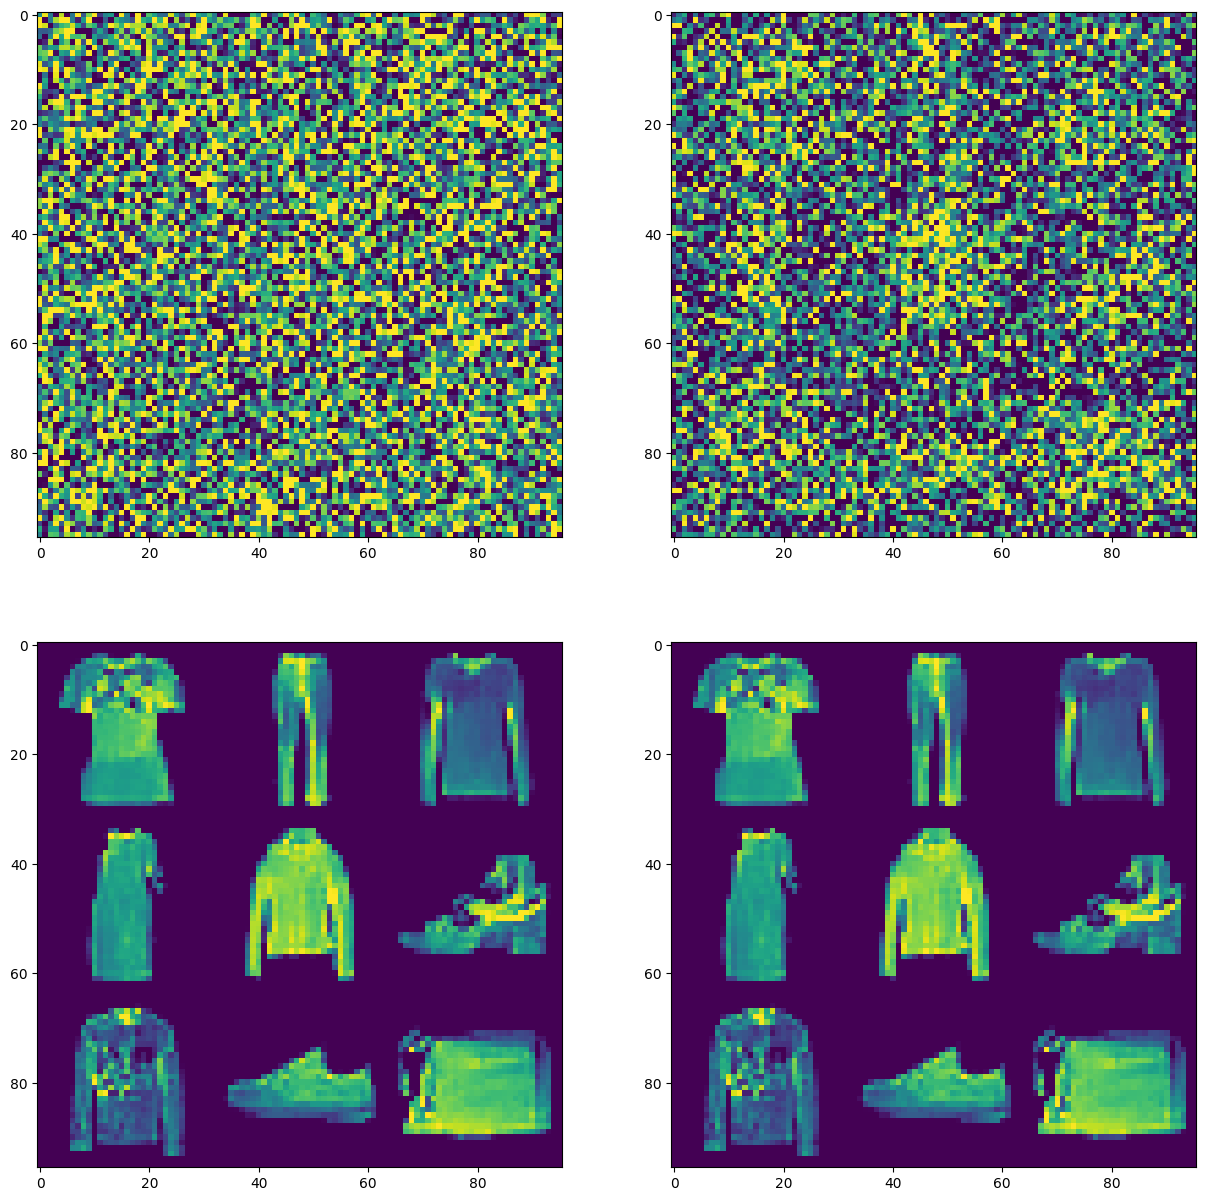

In [27]:
gen_samples = gen_sampels(seed=777)
gen_samples = gen_sampels_prepare(gen_samples)
plot_generate(gen_samples)

<Figure size 640x480 with 0 Axes>

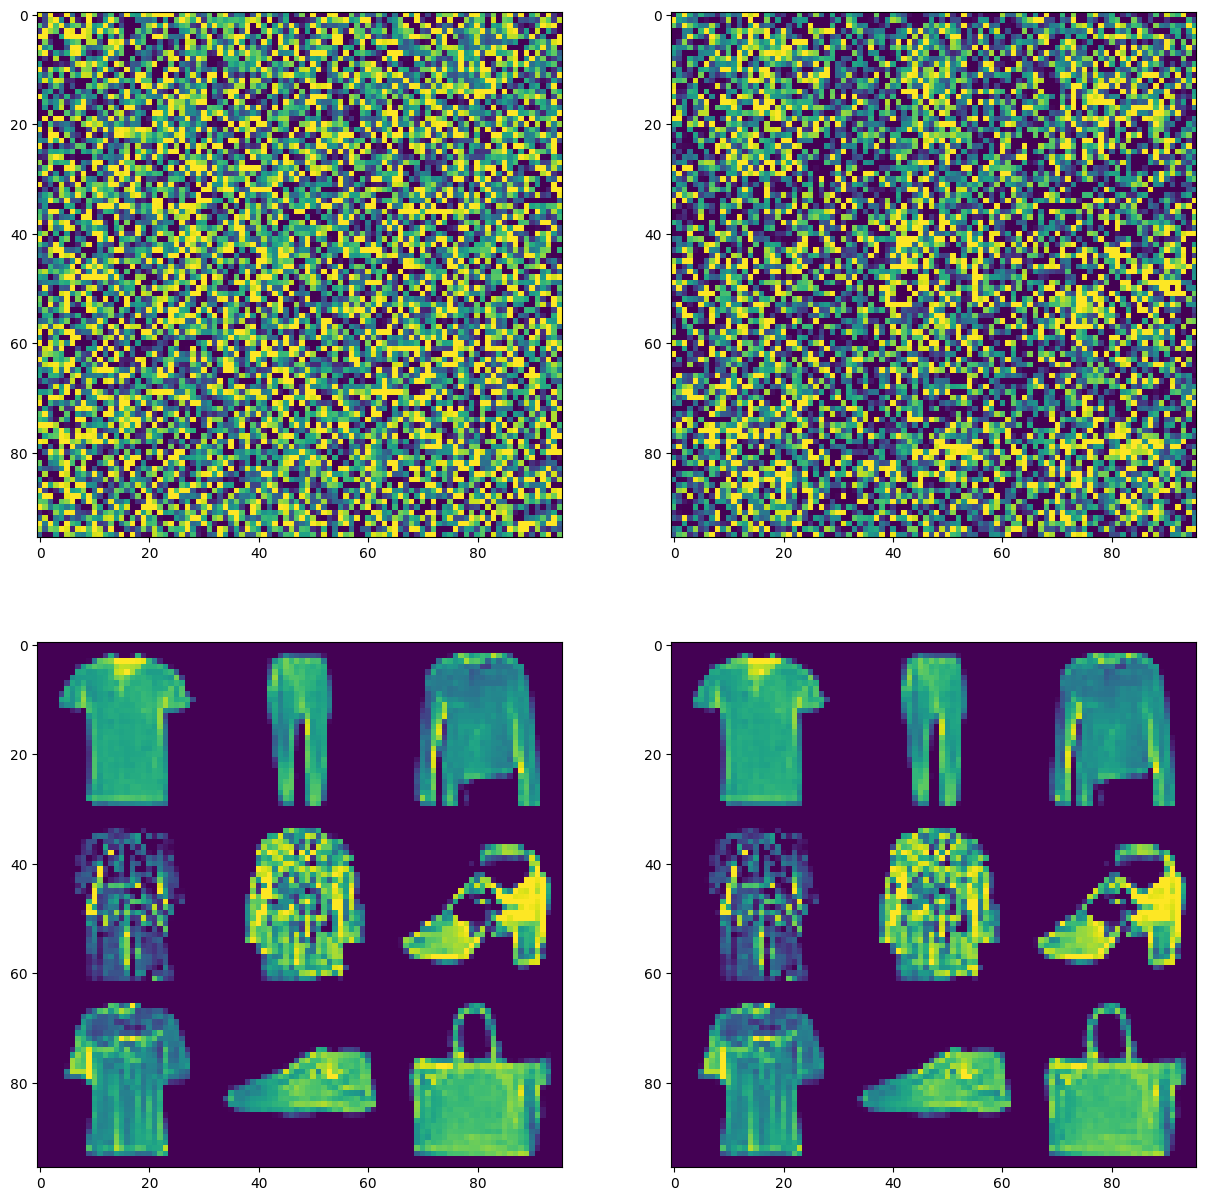

In [28]:
gen_samples = gen_sampels(seed=42)
gen_samples = gen_sampels_prepare(gen_samples)
plot_generate(gen_samples)

<Figure size 640x480 with 0 Axes>

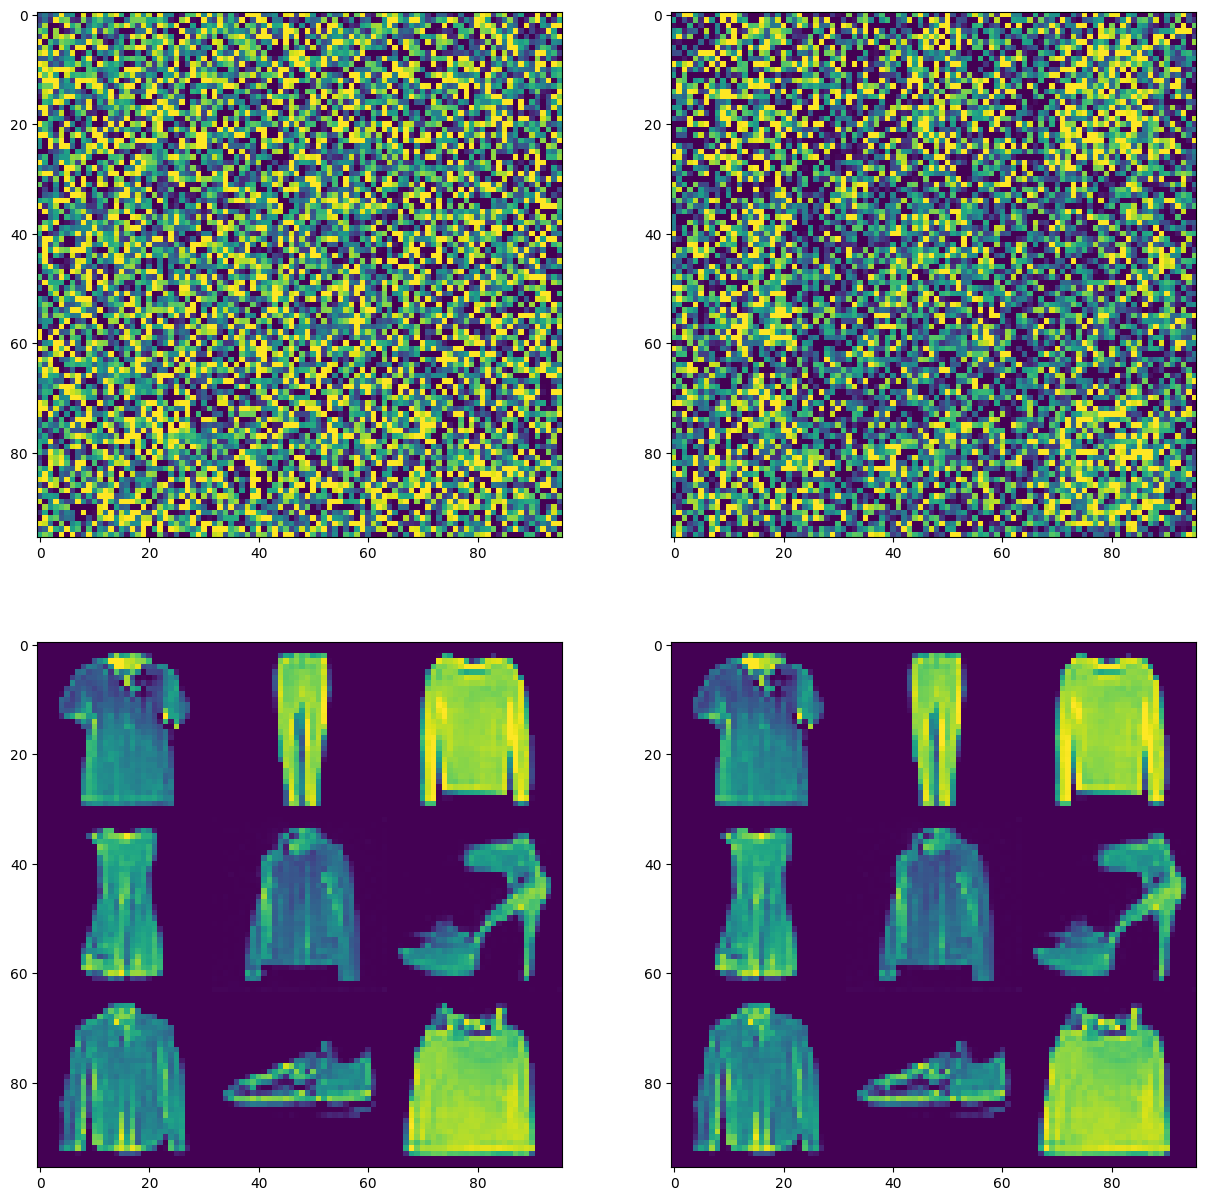

In [29]:
gen_samples = gen_sampels(seed=0)
gen_samples = gen_sampels_prepare(gen_samples)
plot_generate(gen_samples)

References

[1] https://arxiv.org/pdf/2403.18103

[2] https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

[3] https://medium.com/@baicenxiao/understand-classifier-guidance-and-classifier-free-guidance-in-diffusion-model-via-python-e92c0c46ec18

[4] https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869#0d08
